# Initial Experiments Follow-Up

Now that the initial experiments have been performed, a short list of models was constructed.
They are:
* MLP
* LightGBM
* Linear Regression
* Linear SVR

Now, Optuna will be used to tune the hyperparameters for all the models except Linear Regression.
Afterwards, a stacking and voting ensemble will be trained to compare against individual models.
The best model will be selected following the model comparison.

## Experiment Parameters

### LGBM

For LGBM the following parameters and ranges were specified to be included in the hyperparameter space.
* `num_leaves` from 31 to 200, incriments of 1.
* `min_data_in_leaf` from 5 to 50, incriments of 5.
* `num_iterations` from 100 to 500, incriments of 50.
* `learning_rate` from 0.001 to 0.1, incriments of 0.001.

### MLP - SKlearn
The following parameters and ranges were searched to optimize MLP from SKlearn:
* `hidden_layer_sizes` from 10 to 100 in incriments of 5.
* `alpha` from 00001 to 0.001 in incriments of 0.00001.
* `learning_rate_init` from 0.001 to 0.1 in incriments of 0.001.


### Linear SVR
With Linear SVR the following parameters and ranges were searched for hyperparameter optimization:
* `epsilon` from 0 to 10 in incriments of 1.
* `C` from 0 to 5 in incriments of 0.1.

### Ensembles

The stacking and voting ensembles will be tested with the hyperparameter optimized models.
For the stacking ensemble, a LightGBM model with default parameters will be used as the blender layer.
Cross-validation will be skipped for this step, since CV would have been performed on the tuned models.

## Results - Hyperparameter Optimization

In [1]:
import mlflow
from IPython.display import display
import pandas as pd
pd.set_option('display.max_rows', None)
from PIL import Image

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
client = mlflow.tracking.MlflowClient()

In [14]:
run_results = mlflow.search_runs(experiment_names=["fare_amount_initial_optuna"])

In [4]:
all_results = run_results[["params.model", "params.features", "metrics.cv_r2", "metrics.cv_rmse", "metrics.test_r2", "metrics.test_rmse", 'run_id']].sort_values(by="metrics.test_rmse")

In [5]:
display(all_results)

,params.model,params.features,metrics.cv_r2,metrics.cv_rmse,metrics.test_r2,metrics.test_rmse,run_id
2,lgbm,"['trip_distance', 'trip_duration_min', 'r', 't...",0.995730,0.739473,0.995748,0.738115,e5b95b24eb0b4cc28c3afaec6214f038
1,mlp_sklearn,"['trip_distance', 'trip_duration_min', 'r', 't...",0.995581,NaN,0.995592,0.751460,e37d19a4748a485cbc2f91cf508017f1
0,linear_svr,"['trip_distance', 'trip_duration_min', 'r', 't...",0.995054,0.795852,0.995070,0.794778,35d578cf576946a1a13dc25902f5d548


### LGBM Best Parameters

In [19]:
lgbm_results = run_results[["params.model", "params.num_leaves", "params.num_iterations", "params.min_data_in_leaf", "params.learning_rate"]].loc[run_results["params.model"] == 'lgbm']

In [20]:
display(lgbm_results)

,params.model,params.num_leaves,params.num_iterations,params.min_data_in_leaf,params.learning_rate
2,lgbm,163,450,50,0.068


### MLP Best Parameters

In [21]:
mlp_results = run_results[["params.model", "params.alpha", "params.hidden_layer_sizes", "params.learning_rate_init"]].loc[run_results["params.model"] == 'mlp_sklearn']

In [22]:
display(mlp_results)

,params.model,params.alpha,params.hidden_layer_sizes,params.learning_rate_init
1,mlp_sklearn,0.0007300000000000001,80,0.016


### Linear SVR Best Parameters

In [24]:
linsvr_results = run_results[["params.model", "params.epsilon", "params.C"]].loc[run_results["params.model"] == 'linear_svr']

In [25]:
display(linsvr_results)

,params.model,params.epsilon,params.C
0,linear_svr,0.0,2.0


## Results - Ensembles

In [6]:
run_results = mlflow.search_runs(experiment_names=["fare_amount_initial_ensemble"])

In [9]:
all_results = run_results[["params.ensemble_model", "params.features", "metrics.test_r2", "metrics.test_rmse", 'run_id']].sort_values(by="metrics.test_rmse")

In [10]:
display(all_results)

,params.ensemble_model,params.features,metrics.test_r2,metrics.test_rmse,run_id
1,stacking,"['trip_distance', 'trip_duration_min', 'r', 't...",0.995627,0.748527,a815088ec4154ed6abf5494a2d05661c
0,voting,"['trip_distance', 'trip_duration_min', 'r', 't...",0.995563,0.753919,8200546024e644548661a870f062e65a


## Discussion

Given how well most models performed with default parameters, it is no surprise to see minute improvements if any in the model performances with optimized hyperparameters.
The only model that showed improvement was LGBM by about 2 cents in RMSE.

The errors in model predictions seem to come from struggles with common data points in the testing process.
An evaluation of these data points could be useful to understand if the models genuinely struggle or if these are outliers that still persist in the dataset.

Regarding ensemble methods, neither stacking or voting outperforms the tuned LGBM model.
Therefore, the LGBM model will be selected for fare amount predictions.
This model will be considered the baseline model and model performance.

Some areas to consider improvements are re-examining the data for outliers or including additional information to make sure undesired data is not included in the dataset.
Furthermore, additional features like the average speed (was the overall average speed greater than 12MPH) or time related features could also be explored to see if model performance improves.


## Next Steps

The last steps for the initial phase of the project are:
1. Perform several tests with LightGBM models using optimal hyperparameters without specifying `random_state` to verify the general model performance
2. Save the LightGBM model.
3. Deploy the model using FastAPI to enable API model serving using Docker. This can be done locally and also using Huggingface Spaces.

And then it's done!

### LightGBM Results w/o Random State

In [8]:
run_results = mlflow.search_runs(experiment_names=["fare_amount_initial_selection"])

In [9]:
lgbm_results = run_results[["params.model", "metrics.cv_r2", "metrics.cv_rmse", "metrics.test_r2", "metrics.test_rmse", 'run_id']].sort_values(by="metrics.test_rmse")

In [10]:
display(lgbm_results)

,params.model,metrics.cv_r2,metrics.cv_rmse,metrics.test_r2,metrics.test_rmse,run_id
7,lgbm,0.995735,0.739075,0.995748,0.737908,005863784fac4ecba369d1ff408eec3a
1,lgbm,0.995739,0.738714,0.995745,0.738170,185fb5c8c2264fab9b8ba3cf0a815b4a
0,lgbm,0.995733,0.739125,0.995748,0.738383,a152ff29d95b4465b388826719415fe8
6,lgbm,0.995736,0.738801,0.995743,0.738973,6fb5e0826b7a4312a0343a37e022e541
9,lgbm,0.995731,0.739370,0.995739,0.738982,37dad1519ac846b29b599aed6b8862e8
4,lgbm,0.995739,0.738752,0.995735,0.739047,7e676b2c42c44fbe9bc9ae304a512f81
8,lgbm,0.995734,0.739056,0.995733,0.739446,407b69b77e1345208d40bc9e1376836e
3,lgbm,0.995741,0.738618,0.995724,0.739755,1701a23ca4974338aa8b393eeaba4085
5,lgbm,0.995741,0.738710,0.995715,0.740043,f4b22a85ad304d8d95675ca73f58bb33
2,lgbm,0.995734,0.739285,0.995713,0.740419,ba146f18a9f24fa38126c515df4b6100


The results for training 10 LightGBM models shows good results and not much variation with performance metrics.
Now the model is ready for deployment.

## Deploying the Model

The model will be deployed using FastAPI and Docker.
Details can be found in the `/code/model_deployment` directory.

## Conclusion

The initial phase or iteration of this project is complete!
The selected model met the success criteria of having an RMSE < $1.00.
There are some ideas to explore moving forward to see if model performance can be improved.
This includes revisiting data cleaning and including more features from the source dataset to see if additional data cleaning rules can be formulated.
Additionally, more features can be included or engineered to test if model performance can be improved.
It is worth noting that model performance is pretty good right now, so improvements would only be marginal.

## LightGBM Model Artifacts

In [3]:
def show_artifacts(run_id, client):
    run = client.get_run(run_id)
    base_artifact_path = run.info.artifact_uri
    artifacts_list = mlflow.artifacts.list_artifacts(base_artifact_path)
    for artifact in artifacts_list:
        if artifact.is_dir:
            continue
        if "learning_curve_l1" in artifact.path \
            or "learning_curve_mape" in artifact.path \
            or "learning_curve_mae" in artifact.path \
            or "errors_box" in artifact.path \
            or "residual_distribution" in artifact.path \
            or "errors_distance" in artifact.path \
            or "errors_r_vs" in artifact.path :
            continue
        artifact_uri = f"{base_artifact_path}/{artifact.path.split("/")[1]}"
        img = mlflow.artifacts.load_image(artifact_uri=artifact_uri)
        img.show()

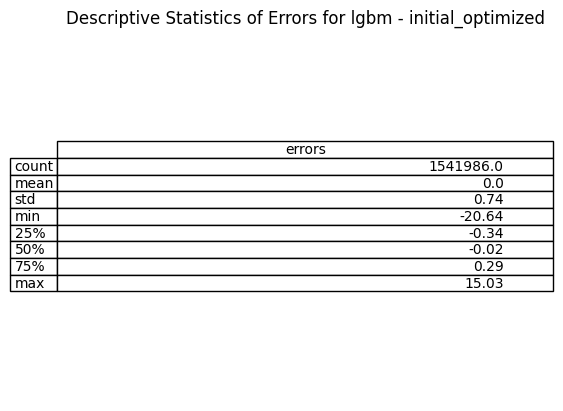

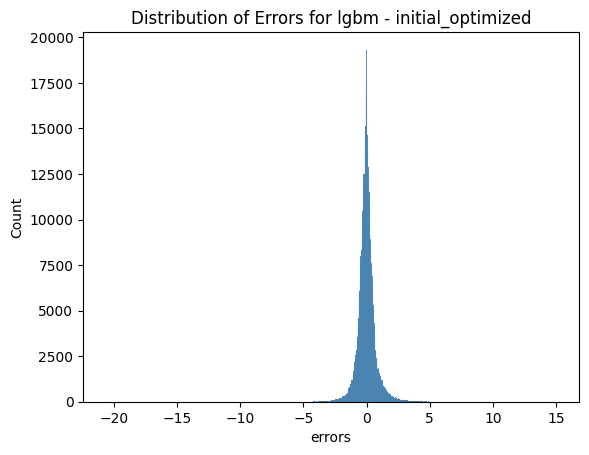

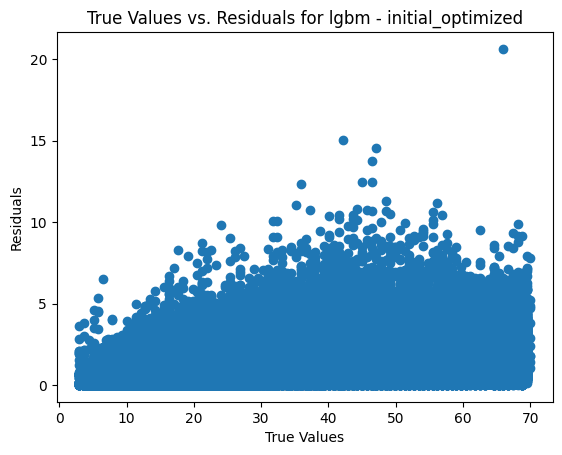

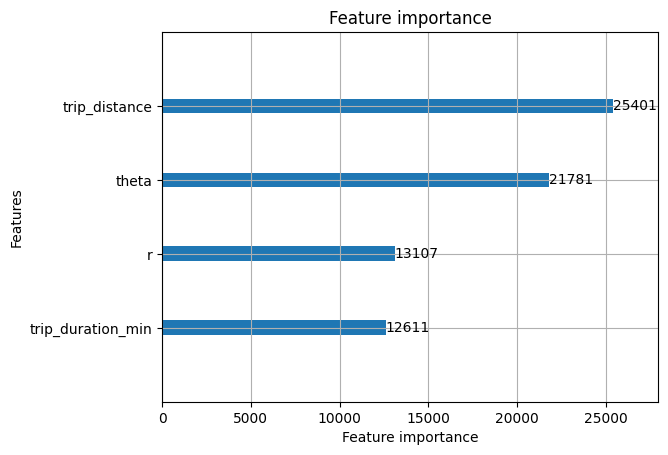

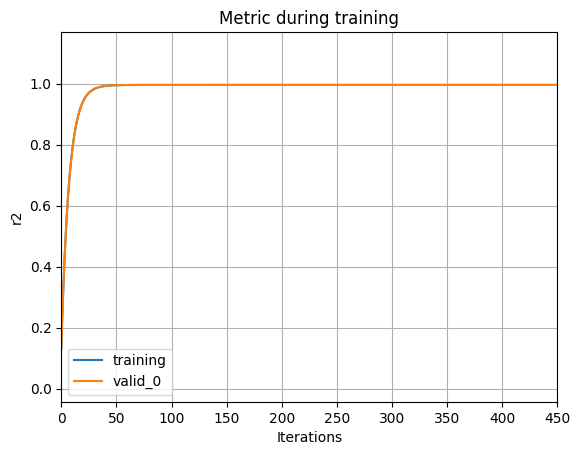

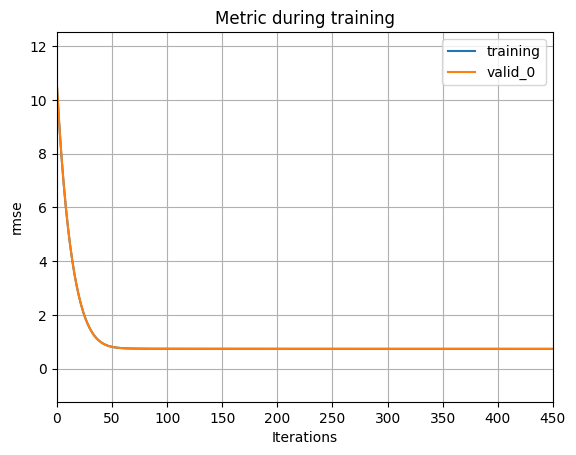

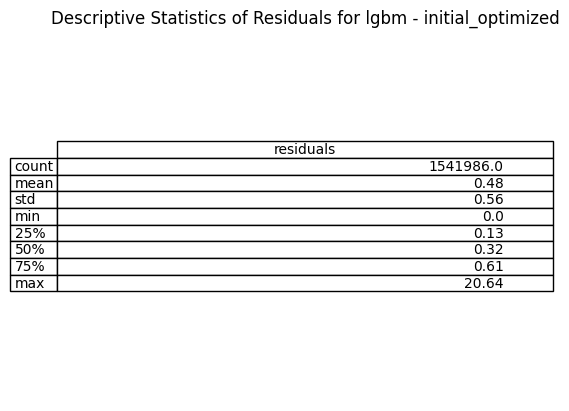

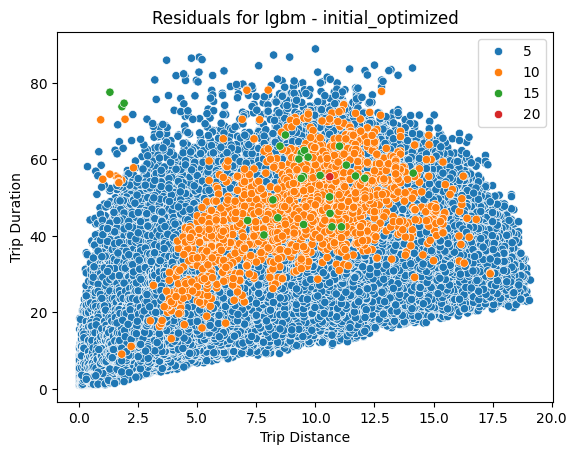

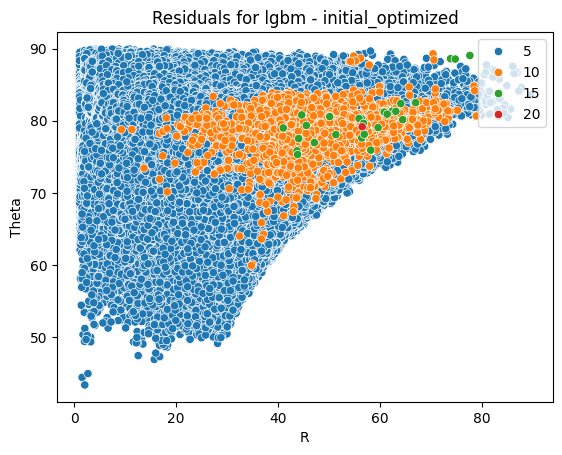

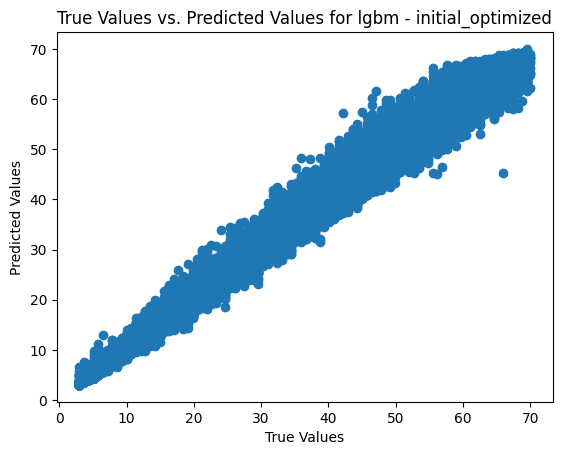

In [4]:
show_artifacts('37dad1519ac846b29b599aed6b8862e8', client)